# Multivariate Time Series Analysis using LSTM

## Summarization of Findings:
The problem at hand is to predict energy consumption based on a time series, but also based on a number of other features (23 other, to be exact). In order to do so, we will leverage the computing powers of a Long-Short-Term Memory neural network. LSTM was a great choice for this problem because, unlike classic linear regression models, it handles multivariate timeseries data very well. I initially tried a VAR and VARMA model on my data but found that it was not as robust as LSTM, so I put that aside for the time being. The RMSE score gets higher the more we aggregate our data (unaggregated to hourly to daily). There are a few factors at play here: one reason for this could be that  the amount of instances decreases, so our model is not able to predict as accurately. The other reason is that as our data changes, our parameters need to change as well, so there should be considerably more thought put into fine tuning the parameters based on the data. In my model, I did not notice any significant over fitting and our RMSE scores were relatively low, so I would say that this is a great first step in training a neural net to predict energy consumption with the given features. 

### How and why I chose my model and parameters

Long-short term memory (LSTM) is a type of Recurrent Neural Network (RNN) that is best suited for classifying, processing and predicting time series data, especially multivariate time series data like we have. The beauty in an LSTM model over other RNNs is that they solve the vanishing gradients problem that occurs when back propogating, since LSTM untis allow gradients to flow through the network unchanged (the error remains in the LSTM unit's cell). The reason I chose this model over a linear regression model like ARIMA, VAR, or VARMA is because after testing my data on all 4 models, I quickly found that LSTM far outperformed the other models in a much shorter amount of time. This leads me to discussing my next point which is picking parameters. The parameters of interest to me in this model were epochs, lookback, and units of RNN. Based off of prior knowledge, I came into testing with epoch = 50, lookback = 1 and unit = 1. I had fairly good results, but wanted to see if I could do better. No matter how much I increased my parameters, the payoff was not enough to warrant the added computation time, so I decided to stick to these for now.

### In this notebook, you can expect to find the following topics:

    -We will write a function which takes a data set and trains and fits a LSTM neural network to our data, printing out a plot showing the error after each ephoc and another plot showing the actual vs. predicted energy consumption for our test data. 
    - We will look at correlation between total energy consumption and each feature 
    - We will do feature extraction and see how our model behaves on a smaller dimensionality.
    - We will analyze data features of our dataset including hourly and daily data and compare how times of day and days of the week differ in energy consumption
 

In [53]:
#import all dependencies
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt 
import seaborn as sns


# convert series to supervised learning to use as input for our network
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#our neural network
def network(dataset, n_train_hours, lookback = 1, n_features=24, epoch=50, batch_sz=72):
    '''
    Parameters:
    -n_train_hours specifies amount of data to set for training 
    -lookback specify the number of lag samples
    -n_features specifies the number of features in dataset
    -epoch specifies how many epochs to run the LSTM on
    -batch_sz specifies the parameter batch_size to be fed into our LSTM
    
    '''
    
    values = dataset.values
    # ensure all data is float
    values = values.astype('float32')
    
    # Normalizing the input data using MinMaxScaler so all input features are on a scale from 0 to 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

     

    # frame as supervised learning
    reframed = series_to_supervised(scaled, lookback, 1)
    #only want to predict one feature, TotalConsp
    reframed.drop(reframed.columns[[i for i in range(n_features,n_features*2)]], axis=1, inplace=True)

    #make sure we have the correct number of columns accounted for
    print(reframed.shape)

    # split into train and test sets
    values = reframed.values
    #hold out appox 30% for testing
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    n_obs = lookback * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    print(train_X.shape, len(train_X), train_y.shape)

    # LSTM expects the input data in a specific 3D format of [test sample size, time steps, no. of input features].
    train_X = train_X.reshape((train_X.shape[0], lookback, n_features))
    test_X = test_X.reshape((test_X.shape[0], lookback, n_features))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


    # Setup our neural network with loss and optimization models
    model = Sequential()
    model.add(LSTM(epoch, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=epoch, batch_size=batch_sz, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()


    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], lookback*n_features))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1)) 
    inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)
    #return error, actual test values, predicted test values
    return rmse, inv_y, inv_yhat

#plot our forcast data vs actual data
def plot_forecast(forecast):
    pyplot.plot(forecast[1],color='blue',label='actual')
    pyplot.plot(forecast[2],color='red', label ='predicted')
    pyplot.legend()
    pyplot.title("Energy Consumption- Actual vs Predicted")
    pyplot.show()
    pass

In [18]:
# load dataset
dataset = read_csv('data.csv', header=0, index_col=0)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19735 entries, 1/11/2016 17:00 to 5/27/2016 18:00
Data columns (total 24 columns):
TotalConsmp    19735 non-null int64
R1             19735 non-null float64
H_1            19735 non-null float64
R2             19735 non-null float64
H_2            19735 non-null float64
R3             19735 non-null float64
H_3            19735 non-null float64
R4             19735 non-null float64
H_4            19735 non-null float64
R5             19735 non-null float64
H_5            19735 non-null float64
R6             19735 non-null float64
H_6            19735 non-null float64
R7             19735 non-null float64
H_7            19735 non-null float64
R8             19735 non-null float64
H_8            19735 non-null float64
R9             19735 non-null float64
H_9            19735 non-null float64
TempOutSide    19735 non-null float64
Press_mm_hg    19735 non-null float64
H_OutSide      19735 non-null float64
Windspeed      19735 non-null float64


# Feature Extraction

We start by taking a closer look at how our features correlate with each other and with our target feature, energy consumption. This is an important step in the data preperation stage of training a neural net for several reasons. One reason is that if we have a huge data set with many features, it can be quite costly to run the model on the entire data set if we don't need to. If we are able to take the most important features to our data set and get similar results as we would by training the model on the entire data set, then this will save a lot of time in training. 

### Feature Correlation

Let's take a look at correlation between our features and Energy Consumption. As the data shows, there is hardly any worthwhile correlationship with any of our features and energy consumption. 

In [19]:
for feature in dataset.columns:
    x = dataset['TotalConsmp'].corr(dataset[feature])
    if x <= -0.7 and x >-1:
        string = 'strong negative correlation'
    elif x> -0.7 and x <= -0.5:
        string = 'moderate negative correlation'
    elif x>-0.5 and x<=-0.3:
        string = 'weak negative correlation'
    elif x>-0.3 and x <0:
        string = 'hardly any negative correlation'
    elif x == 0:
        string = 'no correlation'
    elif x >0 and x <= 0.3:  
        string = 'hardly any positive correlation'
    elif x > 0.3 and x <= 0.5:
        string = 'weak positive correlation'
    elif x >0.5 and x <=0.7:
        string = 'moderate positive correlation'
    elif x >0.7 and x <1:   
        string = 'strong positive correlation'
    else:
        string = 'perfect positive relationship'
        
    print(feature, ': correlation = ', x, string )

TotalConsmp : correlation =  1.0 perfect positive relationship
R1 : correlation =  0.052672770301153395 hardly any positive correlation
H_1 : correlation =  0.0926344440386037 hardly any positive correlation
R2 : correlation =  0.11751091572985038 hardly any positive correlation
H_2 : correlation =  -0.05551332037614427 hardly any negative correlation
R3 : correlation =  0.07614278467856354 hardly any positive correlation
H_3 : correlation =  0.04561846392799706 hardly any positive correlation
R4 : correlation =  0.038891247354098435 hardly any positive correlation
H_4 : correlation =  0.025402244542939063 hardly any positive correlation
R5 : correlation =  0.013421635708341845 hardly any positive correlation
H_5 : correlation =  0.017568733365367926 hardly any positive correlation
R6 : correlation =  0.10953754350231318 hardly any positive correlation
H_6 : correlation =  -0.07000869490955908 hardly any negative correlation
R7 : correlation =  0.015051942103530806 hardly any positive 

### VarianceThreshold 

Variance Threshold is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples. When we try to use this method on on our data, even when the threshold parameter is altered significantly, we see that we do not extract any features. 

In [20]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=.5)
data_reduced = sel.fit_transform(dataset)
data_reduced.shape

(19735, 24)

### Tree-based feature selection

Tree-based estimators (see the sklearn.tree module and forest of trees in the sklearn.ensemble module) can be used to compute feature importances, which in turn can be used to discard irrelevant features (when coupled with the sklearn.feature_selection.SelectFromModel meta-transformer).

From this we see that there are 15 features that stand out to be of most importance. We can cut down on computing time and reduce the risk of over fitting our data by extracting these 15 features. We will do this and compare our model to the model with unextracted features.


Feature ranking:
1. feature 15 (0.051445)
2. feature 17 (0.048487)
3. feature 10 (0.048462)
4. feature 20 (0.048195)
5. feature 9 (0.047866)
6. feature 18 (0.047539)
7. feature 13 (0.047003)
8. feature 19 (0.046874)
9. feature 11 (0.046749)
10. feature 3 (0.046608)
11. feature 1 (0.046504)
12. feature 7 (0.045763)
13. feature 5 (0.044916)
14. feature 2 (0.044833)
15. feature 14 (0.044619)
16. feature 0 (0.039615)
17. feature 4 (0.039215)
18. feature 6 (0.038712)
19. feature 21 (0.037935)
20. feature 8 (0.036523)
21. feature 12 (0.036270)
22. feature 22 (0.034081)
23. feature 16 (0.031789)


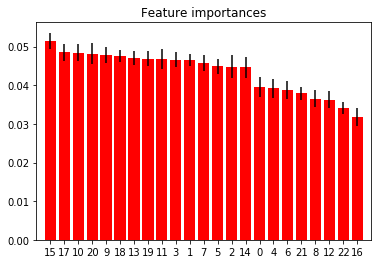

In [21]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel


# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=50,
                              random_state=0)

X = dataset.iloc[:, 1:24]   #X =  23 features
y = dataset.iloc[:, 0]      #y = target feature, TotalConsmp

#fit forest to our data to find level of importance of features
forest.fit(X, y)
importances = forest.feature_importances_    #The feature importances (the higher, the more important the feature). 
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
pyplot.figure()
pyplot.title("Feature importances")
pyplot.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
pyplot.xticks(range(X.shape[1]), indices)
pyplot.xlim([-1, X.shape[1]])
pyplot.show()


        

In [23]:
#we will extract the top 15 features to test on
df = pd.DataFrame(dataset.TotalConsmp)
for f in range(15):
    df[dataset.columns[indices[f]]]= dataset.iloc[:,indices[f]]

df.head()

,TotalConsmp,R8,R9,H_5,Press_mm_hg,R5,H_9,R7,TempOutSide,R6,R2,R1,R4,R3,H_1,H_7
date,,,,,,,,,,,,,,,,
1/11/2016 17:00,90,18.2,17.033333,55.20,733.5,17.166667,45.53,17.200000,6.60,7.026667,19.2,19.89,19.000000,19.79,47.596667,41.626667
1/11/2016 17:10,90,18.2,17.066667,55.20,733.6,17.166667,45.56,17.200000,6.48,6.833333,19.2,19.89,19.000000,19.79,46.693333,41.560000
1/11/2016 17:20,80,18.2,17.000000,55.09,733.7,17.166667,45.50,17.200000,6.37,6.560000,19.2,19.89,18.926667,19.79,46.300000,41.433333
1/11/2016 17:30,90,18.1,17.000000,55.09,733.8,17.166667,45.40,17.133333,6.25,6.433333,19.2,19.89,18.890000,19.79,46.066667,41.290000
1/11/2016 17:40,100,18.1,17.000000,55.09,733.9,17.200000,45.40,17.200000,6.13,6.366667,19.2,19.89,18.890000,19.79,46.333333,41.230000


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19735 entries, 1/11/2016 17:00 to 5/27/2016 18:00
Data columns (total 16 columns):
TotalConsmp    19735 non-null int64
R8             19735 non-null float64
R9             19735 non-null float64
H_5            19735 non-null float64
Press_mm_hg    19735 non-null float64
R5             19735 non-null float64
H_9            19735 non-null float64
R7             19735 non-null float64
TempOutSide    19735 non-null float64
R6             19735 non-null float64
R2             19735 non-null float64
R1             19735 non-null float64
R4             19735 non-null float64
R3             19735 non-null float64
H_1            19735 non-null float64
H_7            19735 non-null float64
dtypes: float64(15), int64(1)
memory usage: 2.6+ MB


(19734, 16)
(13800, 16) 13800 (13800,)
(13800, 1, 16) (13800,) (5934, 1, 16) (5934,)
Train on 13800 samples, validate on 5934 samples
Epoch 1/50
 - 3s - loss: 0.0455 - val_loss: 0.0354
Epoch 2/50
 - 1s - loss: 0.0234 - val_loss: 0.0081
Epoch 3/50
 - 1s - loss: 0.0080 - val_loss: 0.0111
Epoch 4/50
 - 1s - loss: 0.0088 - val_loss: 0.0085
Epoch 5/50
 - 1s - loss: 0.0058 - val_loss: 0.0048
Epoch 6/50
 - 1s - loss: 0.0055 - val_loss: 0.0112
Epoch 7/50
 - 1s - loss: 0.0047 - val_loss: 0.0082
Epoch 8/50
 - 1s - loss: 0.0046 - val_loss: 0.0110
Epoch 9/50
 - 1s - loss: 0.0047 - val_loss: 0.0084
Epoch 10/50
 - 1s - loss: 0.0074 - val_loss: 0.0036
Epoch 11/50
 - 1s - loss: 0.0040 - val_loss: 0.0063
Epoch 12/50
 - 1s - loss: 0.0046 - val_loss: 0.0075
Epoch 13/50
 - 1s - loss: 0.0049 - val_loss: 0.0044
Epoch 14/50
 - 1s - loss: 0.0046 - val_loss: 0.0081
Epoch 15/50
 - 1s - loss: 0.0035 - val_loss: 0.0070
Epoch 16/50
 - 1s - loss: 0.0025 - val_loss: 0.0043
Epoch 17/50
 - 1s - loss: 0.0031 - val_loss

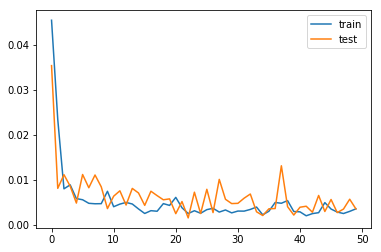

Test RMSE: 4.800


In [56]:
feature_extracted = network(df, 13800, n_features=16, lookback=1, epoch=50)

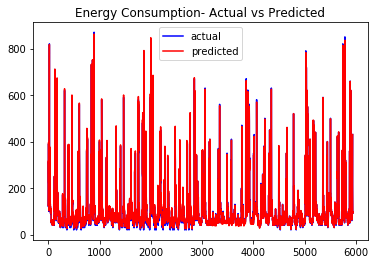

In [57]:
#plot of feature extracted prediction
plot_forecast(feature_extracted)

(19734, 24)
(13800, 24) 13800 (13800,)
(13800, 1, 24) (13800,) (5934, 1, 24) (5934,)
Train on 13800 samples, validate on 5934 samples
Epoch 1/50
 - 4s - loss: 0.0483 - val_loss: 0.0409
Epoch 2/50
 - 1s - loss: 0.0333 - val_loss: 0.0311
Epoch 3/50
 - 1s - loss: 0.0184 - val_loss: 0.0247
Epoch 4/50
 - 1s - loss: 0.0108 - val_loss: 0.0111
Epoch 5/50
 - 1s - loss: 0.0097 - val_loss: 0.0326
Epoch 6/50
 - 1s - loss: 0.0103 - val_loss: 0.0124
Epoch 7/50
 - 1s - loss: 0.0131 - val_loss: 0.0100
Epoch 8/50
 - 1s - loss: 0.0081 - val_loss: 0.0119
Epoch 9/50
 - 1s - loss: 0.0084 - val_loss: 0.0060
Epoch 10/50
 - 1s - loss: 0.0065 - val_loss: 0.0103
Epoch 11/50
 - 1s - loss: 0.0069 - val_loss: 0.0068
Epoch 12/50
 - 1s - loss: 0.0065 - val_loss: 0.0058
Epoch 13/50
 - 1s - loss: 0.0057 - val_loss: 0.0066
Epoch 14/50
 - 1s - loss: 0.0059 - val_loss: 0.0050
Epoch 15/50
 - 1s - loss: 0.0045 - val_loss: 0.0086
Epoch 16/50
 - 1s - loss: 0.0055 - val_loss: 0.0111
Epoch 17/50
 - 1s - loss: 0.0043 - val_loss

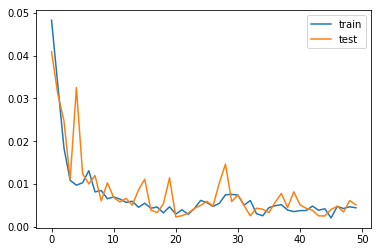

Test RMSE: 6.294


In [59]:
#run the neural network function on our unaggregated, full-featured data
unaggregated = network(dataset, 13800, n_features=24 , lookback=1, epoch=50)

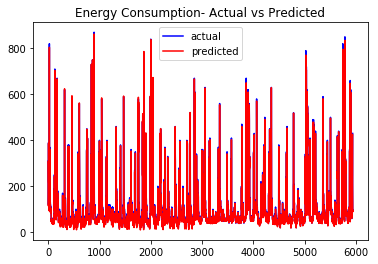

In [60]:
plot_forecast(unaggregated)

### Overview of LSTM for unaggregated data

After running our model many times testing several different parameter choices for parameters such as epoch and batch size, we seem to get an RMSE in the range of 3.0 to 6.5 for both feature extracted and full-featured data. Since it does not seem to impact the performance of our model, in the future we can move forward with our feature extracted data set to cut down on computing time.

In [35]:
#Now we will aggregate our data for average hourly readings
df.index =  pd.to_datetime(df.index)
#average hourly features
hourly = df.resample('H').mean()
hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3290 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Freq: H
Data columns (total 16 columns):
TotalConsmp    3290 non-null float64
R8             3290 non-null float64
R9             3290 non-null float64
H_5            3290 non-null float64
Press_mm_hg    3290 non-null float64
R5             3290 non-null float64
H_9            3290 non-null float64
R7             3290 non-null float64
TempOutSide    3290 non-null float64
R6             3290 non-null float64
R2             3290 non-null float64
R1             3290 non-null float64
R4             3290 non-null float64
R3             3290 non-null float64
H_1            3290 non-null float64
H_7            3290 non-null float64
dtypes: float64(16)
memory usage: 437.0 KB


(3289, 16)
(2303, 16) 2303 (2303,)
(2303, 1, 16) (2303,) (986, 1, 16) (986,)
Train on 2303 samples, validate on 986 samples
Epoch 1/50
 - 2s - loss: 0.0891 - val_loss: 0.0659
Epoch 2/50
 - 0s - loss: 0.0794 - val_loss: 0.0596
Epoch 3/50
 - 0s - loss: 0.0694 - val_loss: 0.0510
Epoch 4/50
 - 0s - loss: 0.0571 - val_loss: 0.0441
Epoch 5/50
 - 0s - loss: 0.0430 - val_loss: 0.0312
Epoch 6/50
 - 0s - loss: 0.0281 - val_loss: 0.0171
Epoch 7/50
 - 0s - loss: 0.0141 - val_loss: 0.0215
Epoch 8/50
 - 0s - loss: 0.0114 - val_loss: 0.0195
Epoch 9/50
 - 0s - loss: 0.0203 - val_loss: 0.0143
Epoch 10/50
 - 0s - loss: 0.0145 - val_loss: 0.0097
Epoch 11/50
 - 0s - loss: 0.0115 - val_loss: 0.0103
Epoch 12/50
 - 0s - loss: 0.0095 - val_loss: 0.0098
Epoch 13/50
 - 0s - loss: 0.0154 - val_loss: 0.0163
Epoch 14/50
 - 0s - loss: 0.0151 - val_loss: 0.0207
Epoch 15/50
 - 0s - loss: 0.0072 - val_loss: 0.0130
Epoch 16/50
 - 0s - loss: 0.0059 - val_loss: 0.0084
Epoch 17/50
 - 0s - loss: 0.0056 - val_loss: 0.0086
E

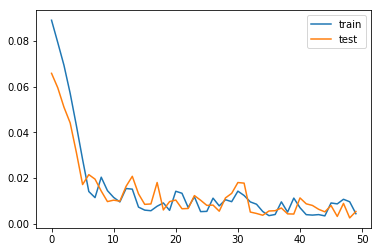

Test RMSE: 3.615


In [46]:
hourly_forecast = network(hourly,int(3290*.7),n_features=16)

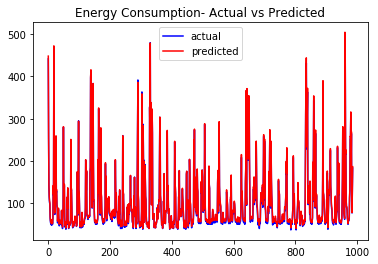

In [47]:
plot_forecast(hourly_forecast)

In [36]:
#Average values for features by the day. We have a total of 138 days of data on record
daily = df.resample('D').mean()
daily.head()

,TotalConsmp,R8,R9,H_5,Press_mm_hg,R5,H_9,R7,TempOutSide,R6,R2,R1,R4,R3,H_1,H_7
date,,,,,,,,,,,,,,,,
2016-01-11,166.666667,18.722063,16.918175,59.011786,735.173810,17.977798,45.106210,17.604028,5.922619,5.891607,20.153333,20.808571,19.492222,20.140972,46.906210,43.026925
2016-01-12,89.930556,18.753033,17.032847,50.569078,742.628125,18.011939,45.680127,17.909869,5.566319,5.350388,19.307655,20.092326,19.772778,19.993646,45.142014,41.944178
2016-01-13,102.430556,18.788722,16.953576,58.006348,754.790625,17.755966,44.691476,18.024485,4.856944,4.979861,18.568513,19.197824,19.009803,19.609213,42.867772,40.436875
2016-01-14,156.388889,18.769959,16.884815,58.117014,749.767361,17.610995,45.428229,17.946759,3.431944,3.492367,19.743131,20.372078,18.694271,20.837581,42.435191,40.125689
2016-01-15,131.319444,19.225237,17.345694,52.490274,754.579861,19.026125,44.534329,18.247612,2.665276,2.662419,21.528172,22.280949,19.615127,20.959074,39.099294,39.424901


(137, 16)
(89, 16) 89 (89,)
(89, 1, 16) (89,) (48, 1, 16) (48,)
Train on 89 samples, validate on 48 samples
Epoch 1/50
 - 2s - loss: 0.4141 - val_loss: 0.2920
Epoch 2/50
 - 0s - loss: 0.2913 - val_loss: 0.1606
Epoch 3/50
 - 0s - loss: 0.2067 - val_loss: 0.1487
Epoch 4/50
 - 0s - loss: 0.1717 - val_loss: 0.2055
Epoch 5/50
 - 0s - loss: 0.1656 - val_loss: 0.2424
Epoch 6/50
 - 0s - loss: 0.1664 - val_loss: 0.2379
Epoch 7/50
 - 0s - loss: 0.1606 - val_loss: 0.2097
Epoch 8/50
 - 0s - loss: 0.1553 - val_loss: 0.1822
Epoch 9/50
 - 0s - loss: 0.1525 - val_loss: 0.1661
Epoch 10/50
 - 0s - loss: 0.1509 - val_loss: 0.1593
Epoch 11/50
 - 0s - loss: 0.1485 - val_loss: 0.1567
Epoch 12/50
 - 0s - loss: 0.1456 - val_loss: 0.1565
Epoch 13/50
 - 0s - loss: 0.1423 - val_loss: 0.1525
Epoch 14/50
 - 0s - loss: 0.1392 - val_loss: 0.1453
Epoch 15/50
 - 0s - loss: 0.1359 - val_loss: 0.1370
Epoch 16/50
 - 0s - loss: 0.1328 - val_loss: 0.1316
Epoch 17/50
 - 0s - loss: 0.1295 - val_loss: 0.1277
Epoch 18/50
 - 0s

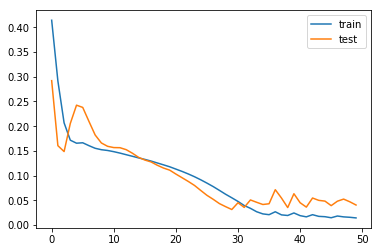

Test RMSE: 9.149


In [31]:
#note that we must shrink our batch size to account for less data
daily_forecast = network(daily,int(138*.65),n_features=16,batch_sz=15)

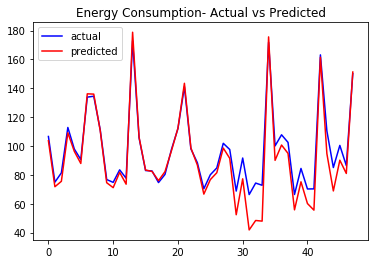

In [32]:
plot_forecast(daily_forecast)

### Overview of Aggregated Data in LSTM Model

Aggregating by hour help up just about as well as unaggregated data in our neural net, however when we aggregated our data by a daily mean, we did not fair as well. With only 138 samples of daily data, we struggle a bit with overfitting and just not having enough data to really learn from, regardless of the epoch parameter.



### A Closer Look at the Data

Let's take this time to digress from the LSTM model and to just analyze and visualize the data that we have. There are some interesting features that we can explore here, like energy consumption in the night time versus during the day, energy consumption on weekends vs weekdays, and so on. 

In [46]:
#Let's examine night time data vs day time data
#nightime data
hours = df.index.hour
mask = (hours >= 18) & (hours <=23)
nighttime = df[mask].groupby(df[mask].index.floor('D')).mean()
nighttime.WeekdayName = nighttime.index.weekday
#daytime data
hours_day = df.index.hour
mask_day = (hours >= 5) & (hours <=12)
daytime = df[mask_day].groupby(df[mask_day].index.floor('D')).mean()
daytime.WeekdayName = daytime.index.weekday
#finding the difference between night time and day time consumption
difference = nighttime - daytime

### Plots of Consumption by Day for Daytime vs Nighttime Usage

We can clearly see much more variance in daytime hours as opposed to night time hours.
Most days dont seem to have too many outliers, except you can note that Friday night has some extreme outlier(s). It would be interesting to check the date of these outliers against a log of cruise activity to glean insight as to what caused these spikes in consumption. Or if it appears to be an anomoly, then this data point can be removed, along with other anomolous outliers.



Text(0.5, 1.0, 'Nighttime Weekday Consumption')

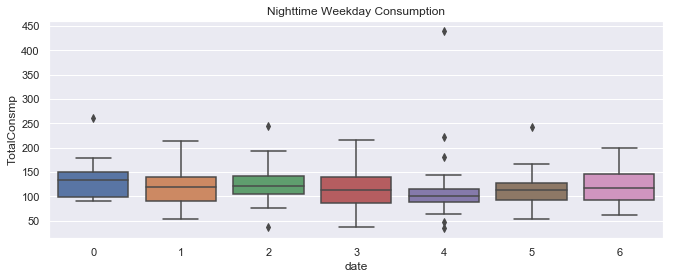

In [60]:
sns.set(rc={'figure.figsize':(11, 4)})
#boxplot of consumption by day for nighttime usage
sns.boxplot(data=nighttime, x=nighttime.WeekdayName, y=nighttime.TotalConsmp).set_title('Nighttime Weekday Consumption')

Text(0.5, 1.0, 'Daytime Weekday Consumption')

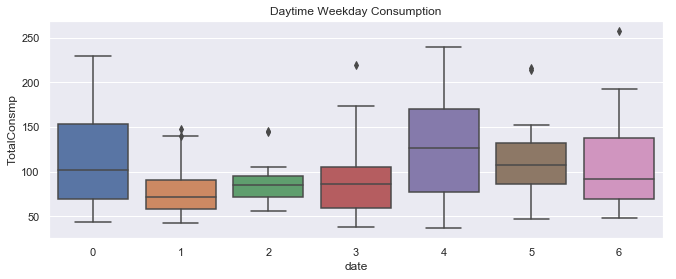

In [61]:
#boxplot of consumption by day for daytime usage
sns.boxplot(data=daytime, x=daytime.WeekdayName, y=daytime.TotalConsmp).set_title('Daytime Weekday Consumption')

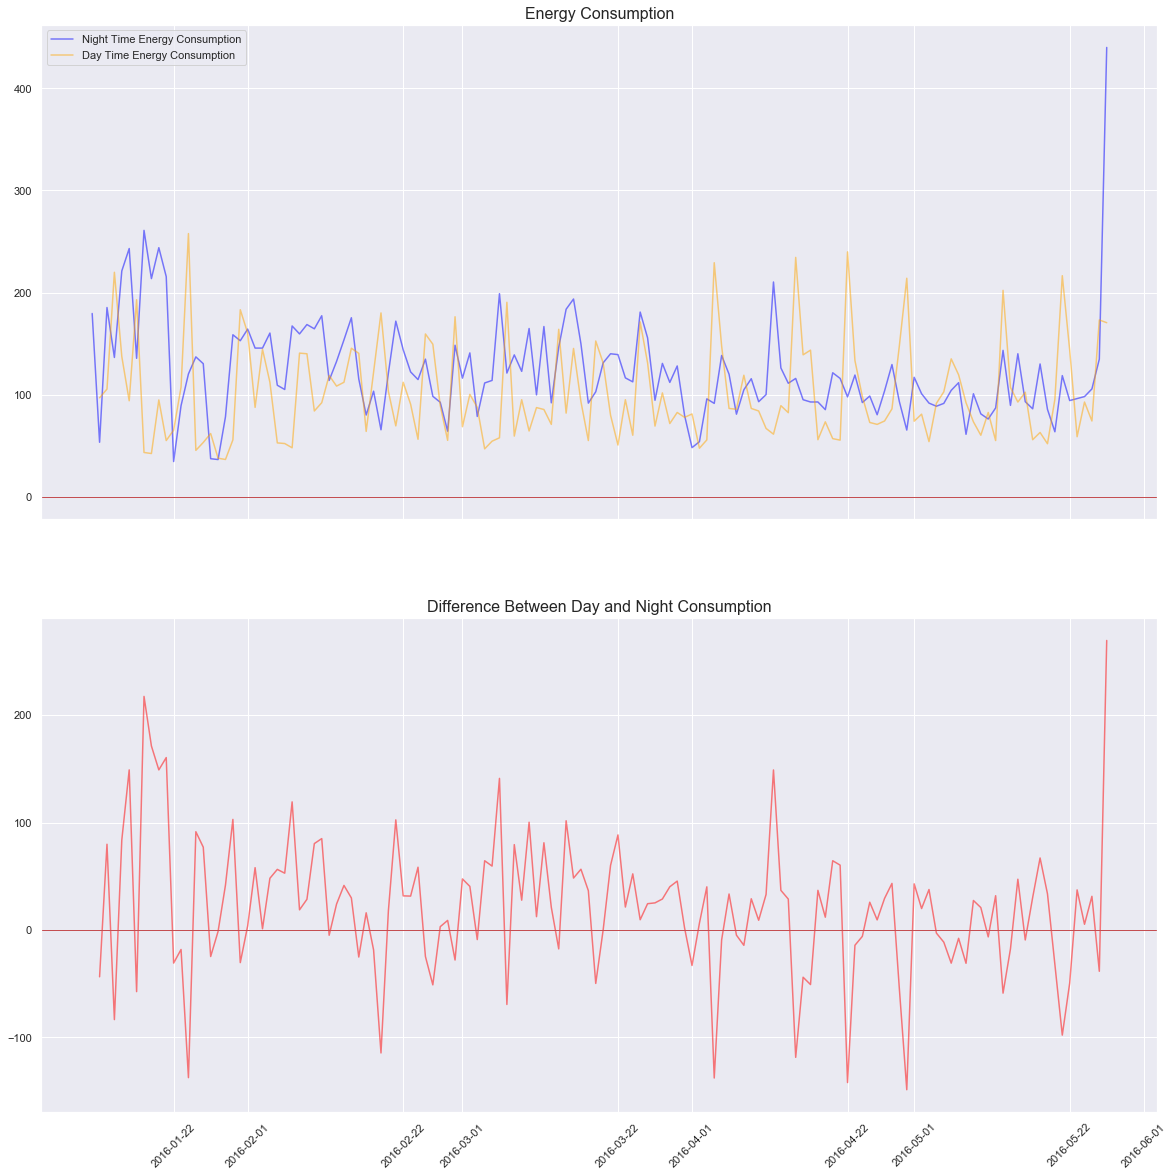

In [63]:
#Plot 2 subplots, one comparing day and night data and one examining the difference
fig, axes = pyplot.subplots(nrows=2, ncols=1, sharex=True, figsize=(20, 20))

axes[0].set_title('Energy Consumption', fontsize=16)
axes[1].set_title('Difference Between Day and Night Consumption', fontsize=16)

axes[0].plot(nighttime.TotalConsmp, color='blue', alpha=.5, label='Night Time Energy Consumption')
axes[0].plot(daytime.TotalConsmp, color='orange', alpha =.5, label='Day Time Energy Consumption')
axes[1].plot(difference.TotalConsmp, color='red', alpha =.5, label='Difference')
pyplot.xticks(rotation=45)
axes[0].legend()
axes[1].legend
axes[0].axhline(linewidth=1, color='r')
axes[1].axhline(linewidth=1, color='r')





In [64]:
'''
Perhaps we are curious to see on what days is more energy used during the night time?
Let's take a look
'''

#find the weekdays with more nightime consumption than daytime
morenight = difference[difference.TotalConsmp >0].index.weekday
morenight = list(morenight)
morenight_dict = {}
for i in range(7):
    x = morenight.count(i)
    morenight_dict[i]= x
    
morenight_dict
#We can see that Tuesday and Wednesday have the most days with elevated nighttime usage


{0: 14, 1: 17, 2: 17, 3: 12, 4: 8, 5: 11, 6: 12}